In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import trackpy as tp
import scipy.signal as signal
import matplotlib.pyplot as plt

from tqdm import tqdm
from cmcrameri import cm
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit


from src.AnalysisFunctions import *
from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack

In [22]:
# experimental parameters
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

dt = 4 # h
dt_holo = 12 # frames per hour
dt_tomo = 4  # frames per hour
blur_factor = 1.5
#holomonitor_scaling = 100

fmin_holo = [188, 1, 1, 130, 1, 1]
fmax_holo = 121

fmin_tomo = 0
fmax_tomo = 40

In [4]:
# Import Holomonitor
holo_folders = ["../../data/Holomonitor/MDCK_01.03.2024/B2-5",
                "../../data/Holomonitor/MDCK_19.03.2024/A1-9",
                "../../data/Holomonitor/MDCK_19.03.2024/A1-12",
                "../../data/Holomonitor/MDCK_19.03.2024/A1-18",
                "../../data/Holomonitor/MDCK_19.03.2024/B1-11",
                "../../data/Holomonitor/MDCK_16.05.2024/B1-9"]

tomo_folders = ["../../data/Tomocube/MDCK_10.02.2025/A2P1/"]

A_holo_theo = 0.25   # mm²
A_tomo_theo = 567**2 / 1e6   # mm²

# Import Tomocube
tomo_files = ["250210.113448.MDCK dynamics.001.MDCK B.A2"]
tomo_paths  = ["../../data/Tomocube/MDCK_10.02.2025/A2P1/"]

holo_colors = cm.devon(np.linspace(0,0.6,6))
tomo_colors = cm.lajolla(np.linspace(0.5,0.5,1))

labels = ["B2-5", "A1-9", "A1-12", "A1-18", "B1-11", "B1-9", "A2P1"]

In [5]:
n_cells_holo = []
area_holo   = []
v_mean_holo = []
v_std_holo  = []
h_mean_holo = []
A_holo = []

for dir in holo_folders:
    df = pd.read_csv(f"{dir}/area_volume_unfiltered.csv")
    area_tmp   = []
    volume_tmp = []
    v_std_tmp = []
    h_mean_tmp = []
    n_cells_tmp  = []
    A_holo_tmp = []

    for f in range(1, np.max(df.frame)+1):
        mask = (df.frame == f)

        area_tmp.append(np.mean(df[mask].A))
        volume_tmp.append(np.mean(df[mask].V))
        v_std_tmp.append(np.std(df[mask].V))
        h_mean_tmp.append(np.mean(df[mask].h_avrg))
        n_cells_tmp.append(np.sum([mask]))
        A_holo_tmp.append(np.sum(df[mask].A))

    area_holo.append(np.array(area_tmp))
    v_mean_holo.append(np.array(volume_tmp))
    v_std_holo.append(np.array(v_std_tmp))
    h_mean_holo.append(np.array(h_mean_tmp))
    n_cells_holo.append(np.array(n_cells_tmp))
    A_holo.append(np.array(A_holo_tmp)*10**(-6))

In [6]:
n_cells_tomo = []
area_tomo   = []
mass_tomo   = []
v_mean_tomo = []
v_std_tomo  = []
h_mean_tomo = []
h_std_tomo  = []
h_max_tomo  = []
h_2D_tomo   = []
n_mean_tomo = []
n_std_tomo  = []
A_tomo = []

areas   = []
n_avrg  = []
volumes = []
heights  = []


for dir in tomo_folders:
    df = pd.read_csv(f"{dir}/area_volume_unfiltered.csv")
    area_tmp   = []
    mass_tmp   = []
    volume_tmp = []
    v_std_tmp  = []
    h_mean_tmp = []
    h_std_tmp  = []
    h_2D_tmp   = []
    n_mean_tmp = []
    n_std_tmp  = []
    h_max_tmp  = []
    n_cells_tmp = []
    A_tomo_tmp = []

    for f in range(1,np.max(df.frame)+1):
        mask = (df.frame == f)

        area_tmp.append(np.mean(df[mask].A))
        mass_tmp.append(np.mean(df[mask].m))
        volume_tmp.append(np.mean(df[mask].V))
        v_std_tmp.append(np.std(df[mask].V))
        h_mean_tmp.append(np.mean(df[mask].h_avrg))
        h_std_tmp.append(np.std(df[mask].h_avrg))
        h_max_tmp.append(np.mean(df[mask].h_max))
        h_2D_tmp.append(np.mean(df[mask].h_2D))
        n_mean_tmp.append(np.mean(df[mask].n_avrg))
        n_std_tmp.append(np.std(df[mask].n_avrg))
        n_cells_tmp.append(np.sum([mask]))
        A_tomo_tmp.append(np.sum(df[mask].A))

    areas.append(df.A.values)
    n_avrg.append(df.n_avrg.values)
    heights.append(df.h_avrg.values)
    volumes.append(df.V.values)

    area_tomo.append(np.array(area_tmp))
    mass_tomo.append(np.array(mass_tmp))
    v_mean_tomo.append(np.array(volume_tmp))
    v_std_tomo.append(np.array(v_std_tmp))
    h_mean_tomo.append(np.array(h_mean_tmp))
    h_std_tomo.append(np.array(h_std_tmp))
    h_max_tomo.append(np.array(h_max_tmp))
    h_2D_tomo.append(np.array(h_2D_tmp))
    n_mean_tomo.append(np.array(n_mean_tmp))
    n_std_tomo.append(np.array(n_std_tmp))
    n_cells_tomo.append(np.array(n_cells_tmp))
    A_tomo.append(np.array(A_tomo_tmp)*10**(-6))

areas   = np.concatenate(areas)
n_avrg  = np.concatenate(n_avrg)
heights = np.concatenate(heights)
volumes = np.concatenate(volumes)

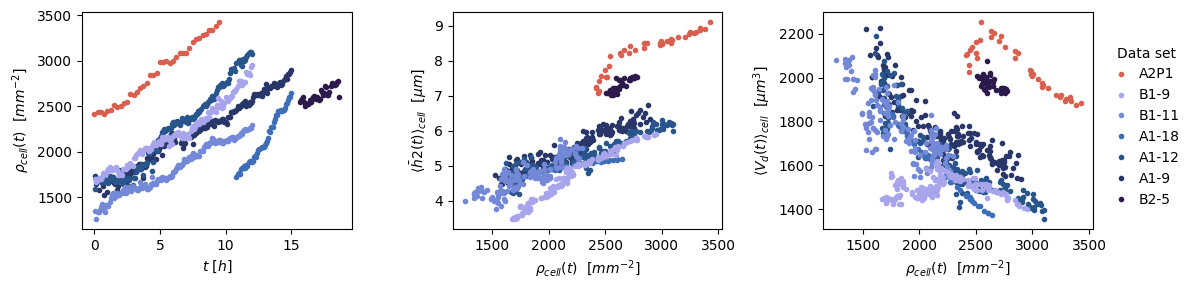

In [29]:
# Plot evolution of area and height vs cell density
fig, ax = plt.subplots(1,3, figsize=(12,3))
for i in range(len(holo_folders)):
    frames = (fmin_holo[i] + np.arange(len(n_cells_holo[i])))/12
    ax[0].plot(frames, n_cells_holo[i] / A_holo[i],     '.', color=holo_colors[i])
    ax[1].plot(n_cells_holo[i] / A_holo[i], h_mean_holo[i],     '.', color=holo_colors[i])
    ax[2].plot(n_cells_holo[i] / A_holo[i], v_mean_holo[i]/1.4, '.', color=holo_colors[i], label=labels[i])

for i in range(len(tomo_folders)):
    frames = np.arange(len(n_cells_tomo[i]))/4
    ax[0].plot(frames, n_cells_tomo[i] / A_tomo[i],   '.', color=tomo_colors[i])
    ax[1].plot(n_cells_tomo[i] / A_tomo[i], h_2D_tomo[i],   '.', color=tomo_colors[i])
    #ax[0].plot(n_cells_tomo[i] / A_tomo[i], h_mean_tomo[i], '.', color=tomo_colors[i])
    ax[2].plot(n_cells_tomo[i] / A_tomo[i], (mass_tomo[i] - 1.33*v_mean_tomo[i])/(1.4*(1.38-1.33)), '.', color=tomo_colors[i], label=labels[len(holo_folders)+i])
    #ax[1].plot(n_cells_tomo[i] / A_tomo[i], v_mean_tomo[i], '.', color=tomo_colors[i], label=labels[len(holo_folders)+i])
    

ax[0].set(xlabel=r"$t ~[h]$", ylabel=r"$\rho_{cell}(t) ~~[mm^{-2}]$")
ax[1].set(xlabel=r"$\rho_{cell}(t) ~~[mm^{-2}]$", ylabel=r"$\langle \bar{h}2(t)\rangle_{cell} ~~[\mu m]$")
ax[2].set(xlabel=r"$\rho_{cell}(t) ~~[mm^{-2}]$", ylabel=r"$\langle V_d(t)\rangle_{cell}  ~~[\mu m^3]$")


# # analytical expectation
# rho = np.linspace(1000, 3500, 100)
# ax[0].plot(rho, func_area(rho, *popt))
# print(popt*1e-6)


fig.tight_layout(rect=[0, 0, 0.87, 1], h_pad=3)
ax[2].legend(loc='upper center',
             bbox_to_anchor=(1.2, 0.9),
             ncol=1,
             reverse=True,
             frameon=False,
             fancybox=True,
             handlelength=1,
             title="Data set",
             alignment='center')

fig.tight_layout()
fig.savefig("../../figs/h_V_cell_density.png")

In [16]:
len(h_mean_holo)

6

In [ ]:
folder = "../../data/Holomonitor/MDCK_19.03.2024/"
file = "A1-12"

# import data
h_im = import_holomonitor_stack(folder, file, f_min=fmin_holo, f_max=fmax_holo)
df = pd.read_csv(f"{folder}{file}/area_volume_filtered.csv")
tracks = tp.link(df, search_range=10, memory=5)
tracks = tp.filter_stubs(tracks, threshold=5)

# file = "250210.113448.MDCK dynamics.001.MDCK B.A2"
# folder = "../../data/Tomocube/MDCK_10.02.2025/A2P1/"

# _, h_im = import_tomocube_stack(folder, file, f_min=0, f_max=40, h_scaling=vox_to_um[0])
# df = pd.read_csv(f"{folder}/area_volume_unfiltered.csv")

In [8]:
hblur = np.zeros_like(h_im)

for f in range(len(h_im)):
    r_cell = average_cell_radius(df, f, pix_to_um, blur_factor=0.75)
    hblur_tmp = gaussian_filter(h_im[f], r_cell)

    hblur[f] = hblur_tmp #- np.mean(hblur_tmp)

In [81]:
def autocorrelation(im):
    # center input around zero (ensure negative correlation)
    im = im - np.mean(im)
    im = im# / np.max(im)

    # compute FFT of image
    fft_im  = np.fft.fft2(im, norm="ortho")
    #fft_im = np.fft.fftshift(fft_im)

    ifft_im = np.fft.ifft2(np.abs(fft_im)**2, norm="ortho")
    ifft_im = np.fft.fftshift(ifft_im)

    # normalize output
    ifft_im_norm = np.real(ifft_im)# / np.max(np.real(ifft_im))

    return ifft_im_norm, np.real(fft_im)

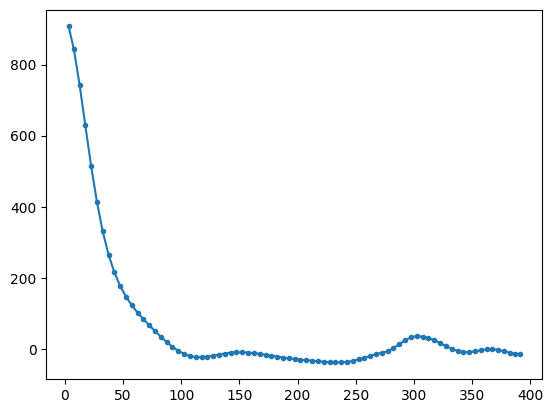

In [86]:
auto_corr, freq = autocorrelation(hblur[0, 0:1001, 0:1001])
dist, corr, _ = radial_distribution(auto_corr, pix_to_um)
#plt.imshow(auto_corr)
plt.plot(dist, corr, '.-')
#plt.xscale("log")
#plt.yscale("log")

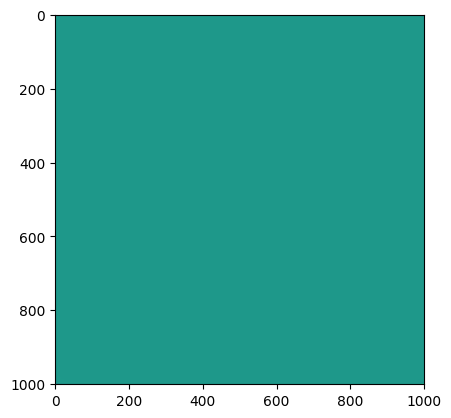

In [ ]:
plt.imshow(abs(freq))

In [38]:
im = hblur #- np.mean(hblur, axis=(1,2))[:,np.newaxis,np.newaxis]

auto_corr = np.zeros(len(hblur))

for t in range(len(h_im)):
    auto_corr[t] = np.mean((im[0] * im[t])) - np.mean(im[0])*np.mean(im[t])

In [ ]:
time = (np.arange(len(hblur))) / 12

fig, ax = plt.subplots(1,1)
ax.plot(time, auto_corr, '.', label="A1-12")
ax.set(xlabel="time [h]", ylabel="C(t)")
#plt.savefig("../../figs/fluctuations/time_correlation_holomonitor.png")

[Text(0.5, 23.52222222222222, 'time [h]'),
 Text(42.722222222222214, 0.5, 'C(t)')]

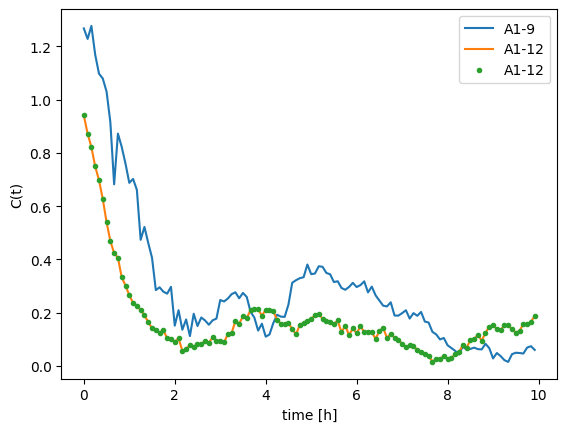

In [43]:
ax.legend()
fig
#fig.savefig("../../figs/fluctuations/time_correlation_holomonitor.png")

In [ ]:
dist, corr, std  = radial_distribution(im_corr, pix_to_um, binsize=1)
plt.plot(dist, corr)

def func(r, l, a):
    return np.exp(-r/l) - a

param, cov = curve_fit(func, dist[dist < 100], corr[dist < 100], )

plt.plot(dist, func(dist, *param), "--")